In [1]:
%cd "C:/app"
# github: https://github.com/tensorflow/tensorflow 
# docs: https://www.tensorflow.org/api_docs/python/tf
# examples: https://www.tensorflow.org/

C:\app


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme()
sns.set_style('whitegrid')

In [3]:
# load data
from sklearn.preprocessing import scale


data = pd.read_csv("./data/ann/features_targets.csv", index_col="Timestamp", parse_dates=["Timestamp"])


excluded_cols = ['Open',
 'High',
 'Low',
 'Close',
 'Symbol']

all_cols = [c for c in data.columns if c not in excluded_cols ]
data = data[all_cols]

data.loc[:, data.columns] = scale(data)

features_cols = data.columns[data.columns.str.contains("TARGET") == False]
features = data[features_cols]
features.describe()

target_col = "TARGET_LOGRET_1"
targets = data[[target_col]]
targets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24414 entries, 2021-01-18 10:00:00 to 2022-12-30 22:30:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET_LOGRET_1  24414 non-null  float64
dtypes: float64(1)
memory usage: 381.5 KB


**Automate model generation**

In [4]:
# package pip tensorflow
# github: https://github.com/tensorflow/tensorflow 
# docs: https://www.tensorflow.org/api_docs/python/tf
# examples: https://www.tensorflow.org/

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input



In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


**Playaround**

In [6]:
X = features[features.columns[:3]].head(2000)
y = targets.head(2000)


model = Sequential()

layer_input = Input(shape=(3,))
layer_hidden_1 = Dense(10, activation='tanh')

layer_output = Dense(1, activation="tanh")

model.add(layer_input)
model.add(layer_hidden_1)
model.add(layer_output)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 51 (204.00 Byte)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: xlabel='epoch'>

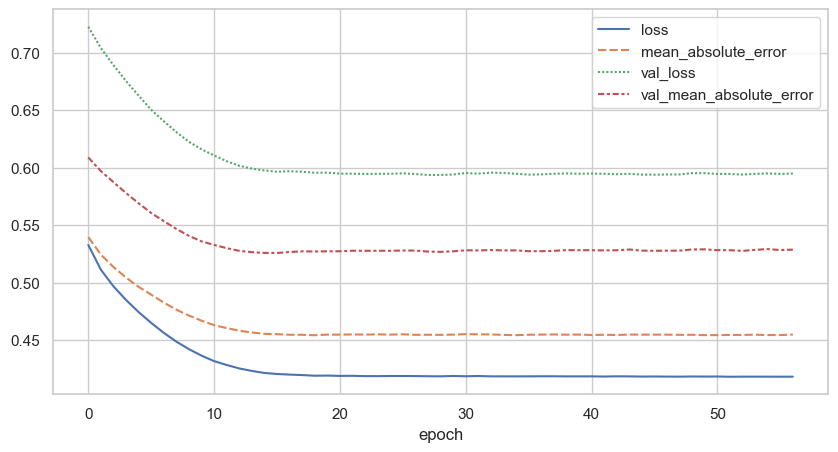

In [7]:
#training
model.compile(loss="mean_squared_error", 
              metrics=["mean_absolute_error"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(X, 
                    y, 
                    epochs=100, 
                    validation_split=0.3, 
                    verbose=0,
                    batch_size=256,
                    callbacks=[early_stop]
                   )

history_df = pd.DataFrame(history.history)
history_df.index.name = "epoch"
sns.lineplot(data=history_df)



In [8]:
model.predict(X)

63/63 [==============================] - 0s 3ms/step


array([[0.07377484],
       [0.07312321],
       [0.07509069],
       ...,
       [0.05869865],
       [0.05351867],
       [0.05433014]], dtype=float32)

**parameter tunning and cross validation**

In [9]:
from sklearn.model_selection import GridSearchCV

# github scikeras https://github.com/adriangb/scikeras
from scikeras.wrappers import KerasRegressor


In [10]:
def create_model(layer_node_n):
    # layer_node_n =  int(compile_kwargs["layer_node_n"])
    model = Sequential()
    
    layer_input = Input(shape=(3,))
    layer_hidden_1 = Dense(layer_node_n, activation='tanh')
    layer_output = Dense(1, activation="tanh")
    
    model.add(layer_input)
    model.add(layer_hidden_1)
    model.add(layer_output)

    model.compile(loss="mean_squared_error")

    return model

In [11]:
k_model = KerasRegressor(model=create_model, layer_node_n=10, verbose=1)
k_model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'layer_node_n'])

In [12]:
# create cv
from sklearn.model_selection import TimeSeriesSplit
train_length=1000
test_length=200
size = len(X)
n_splits = int((size -1) / test_length)

cv = TimeSeriesSplit(
            max_train_size=train_length, 
            test_size=test_length,
            n_splits=n_splits
        );

In [13]:
# TUNNING
batch_size = [80, 100]
epochs = [10, 50]
layer_node_n = [10, 20]

param_grid = dict(batch_size=batch_size, epochs=epochs, layer_node_n=layer_node_n)
param_grid

grid = GridSearchCV(estimator=k_model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=cv,
                   verbose=1)


In [14]:
# Train
grid_result = grid.fit(X, y)

grid_result.best_params_
grid_result.best_score_



Fitting 9 folds for each of 8 candidates, totalling 72 fits
Epoch 1/50
20/20 [==============================] - 0s 5ms/step - loss: 0.6594
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 0.6108
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.5728
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5413
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5156
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4966
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4848
Epoch 8/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4774
Epoch 9/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4745
Epoch 10/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4730
Epoch 11/50
20/20 [==============================] - 0s 10ms/step - loss: 0.4725
Epoch 12/50
20/20 [==============================] - 0s 7ms/step - l

-0.011311727202999507

In [15]:
grid_result.predict(X)

cv_results = pd.DataFrame(grid_result.cv_results_)
cv_results.filter(like="score")
cv_results


20/20 [==============================] - 0s 4ms/step


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_layer_node_n,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,mean_test_score,std_test_score,rank_test_score
0,1.870864,0.255222,0.307390,0.089268,80,10,10,"{'batch_size': 80, 'epochs': 10, 'layer_node_n...",-0.132315,-0.277437,-0.443608,-0.043126,-0.006118,-0.009996,-0.006034,-0.032440,0.002677,-0.105377,0.146977,8
1,1.670422,0.353652,0.271251,0.104116,80,10,20,"{'batch_size': 80, 'epochs': 10, 'layer_node_n...",-0.058427,0.008644,-0.067533,-0.030982,-0.013375,-0.003722,-0.001540,0.000807,-0.005498,-0.019069,0.025739,5
2,5.294464,1.696649,0.667002,0.246390,80,50,10,"{'batch_size': 80, 'epochs': 50, 'layer_node_n...",-0.001307,0.007811,-0.032978,-0.060510,-0.024665,-0.006247,0.003052,-0.016537,-0.000277,-0.014629,0.020591,4
3,6.107111,0.594144,0.625791,0.198481,80,50,20,"{'batch_size': 80, 'epochs': 50, 'layer_node_n...",-0.004435,0.017348,-0.048722,-0.053356,-0.024886,0.000938,0.000498,-0.003901,0.001163,-0.012817,0.022852,2
4,2.923685,0.332419,0.558126,0.240379,100,10,10,"{'batch_size': 100, 'epochs': 10, 'layer_node_...",-0.312119,-0.113688,-0.199803,-0.005476,-0.000741,-0.010109,-0.009785,-0.092795,-0.002148,-0.082963,0.103903,7
5,1.957781,0.394118,0.430613,0.185710,100,10,20,"{'batch_size': 100, 'epochs': 10, 'layer_node_...",-0.008143,-0.149171,-0.016686,-0.051557,-0.019508,-0.008872,0.004207,-0.025262,-0.001831,-0.030758,0.044546,6
6,5.019265,1.500174,0.603750,0.270201,100,50,10,"{'batch_size': 100, 'epochs': 50, 'layer_node_...",-0.010080,0.018896,-0.019994,-0.056572,-0.027343,-0.003103,0.002075,0.003335,-0.009021,-0.011312,0.020443,1
7,5.520215,0.458061,0.526267,0.275340,100,50,20,"{'batch_size': 100, 'epochs': 50, 'layer_node_...",-0.014848,0.015168,-0.037495,-0.042861,-0.013679,-0.003519,0.002655,-0.019899,-0.008310,-0.013643,0.017288,3
